A collection of analyses for models trained specifically for the stacking task. Models include
- ACT (200k trained from scratch)
- PI0 (20k, finetuned)
- SmolVLA (20k, finetuned)


In [3]:
import torch
from utils import (
    align_chunks,
    reduce_chunks_dim,
    compute_frames_chunks_differences
)

from datasets import load_dataset
import matplotlib.pyplot as plt

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/Users/francescocapuano/miniconda3/envs/smolvlaenv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/francescocapuano/miniconda3/envs/smolvlaenv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /Users/francescocapuano/miniconda3/envs/smolvlaenv/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth


/Users/francescocapuano/miniconda3/envs/smolvlaenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# ACT

In [2]:
dataset_id = "fracapuano/act_stacking_action_chunks"

In [3]:
dataset = load_dataset(dataset_id, split="train").with_format("torch")

chunks_differences, frames_diffs = compute_frames_chunks_differences(dataset, n_chunk_in_pairs=2)

100%|██████████| 1599/1599 [03:41<00:00,  7.22it/s]


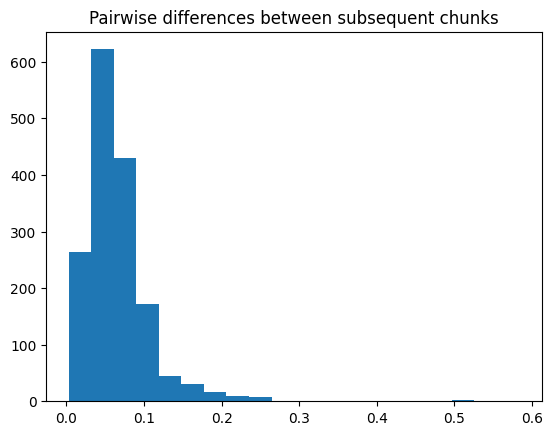

In [4]:
fig, ax = plt.subplots()
ax.hist(chunks_differences, bins=20)

ax.set_title("Pairwise differences between subsequent chunks")
plt.show()

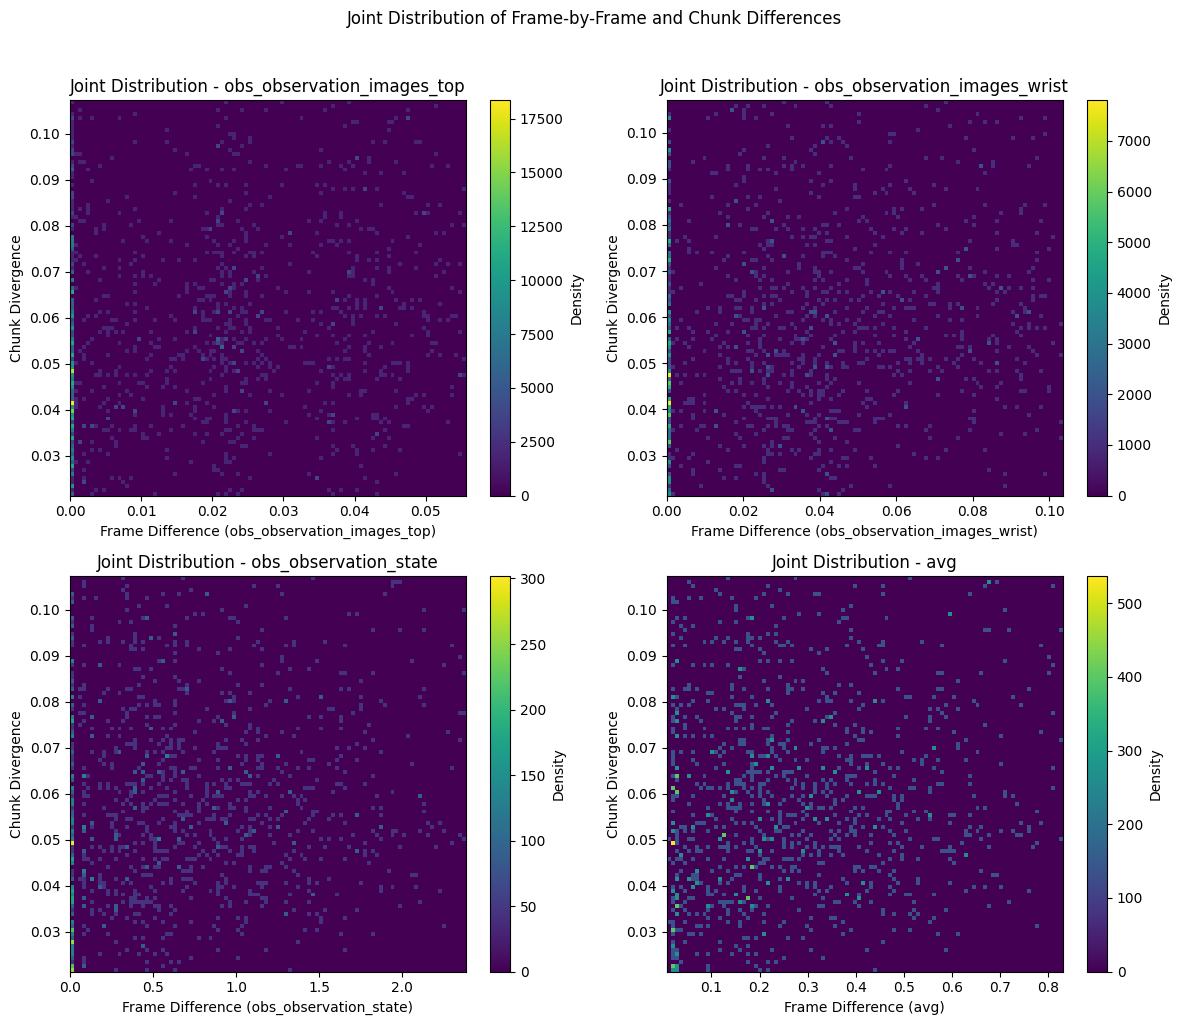

In [5]:
from utils import perceptual_keys, vector_keys
import numpy as np

keys = [*perceptual_keys, *vector_keys, "avg"]
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

for i in range(4):
    current = ax[i//2, i%2]
    
    x = np.array([fd[keys[i]] for fd in frames_diffs])
    y = chunks_differences.numpy()
    
    # Calculate percentile bounds
    x_lower, x_upper = np.percentile(x, [10, 90])
    y_lower, y_upper = np.percentile(y, [10, 90])
    
    # Filter data within the percentile bounds
    mask = (x >= x_lower) & (x <= x_upper) & (y >= y_lower) & (y <= y_upper)
    x = x[mask]
    y = y[mask]
    
    # Create 2D histogram
    h = current.hist2d(
        x, y,
        bins=100,
        density=True  # This normalizes the histogram
    )
    
    # Add colorbar
    plt.colorbar(h[3], ax=current, label='Density')
    
    current.set_xlabel(f'Frame Difference ({keys[i]})')
    current.set_ylabel('Chunk Divergence')
    current.set_title(f'Joint Distribution - {keys[i]}')

fig.suptitle('Joint Distribution of Frame-by-Frame and Chunk Differences', y=1.02)
plt.tight_layout()

In [6]:
avg_distance = torch.tensor([fd[keys[i]] for fd in frames_diffs])
torch.corrcoef(torch.vstack((avg_distance, chunks_differences)))[0,1].item()

0.0773848220705986

In [7]:
pca = reduce_chunks_dim(dataset)

1D projection of action chunk explains variance:  [0.5531393]


In [8]:
avg_distance = torch.tensor([fd[keys[i]] for fd in frames_diffs])
torch.corrcoef(torch.vstack((avg_distance, chunks_differences)))[0,1].item()

0.0773848220705986

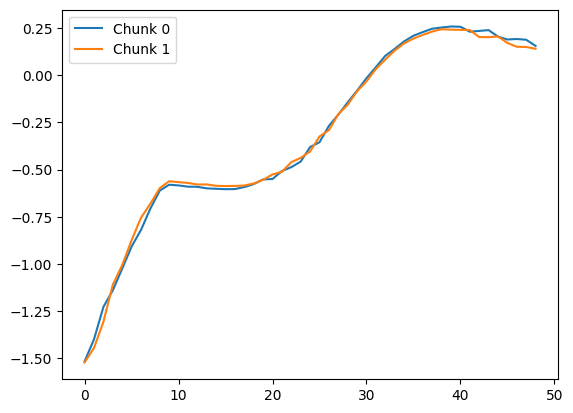

In [9]:
import torch
idx = torch.median(chunks_differences, 0).indices.item()

chunks = dataset[idx:idx+2]["action_chunks"]

aligned_chunks = align_chunks(chunks)
reduced_dim_chunks = [pca.transform(aligned_chunks[i]) for i in range(len(aligned_chunks))]

for i in range(len(reduced_dim_chunks)):
    plt.plot(reduced_dim_chunks[i], label=f"Chunk {i}")

plt.legend()
plt.show()

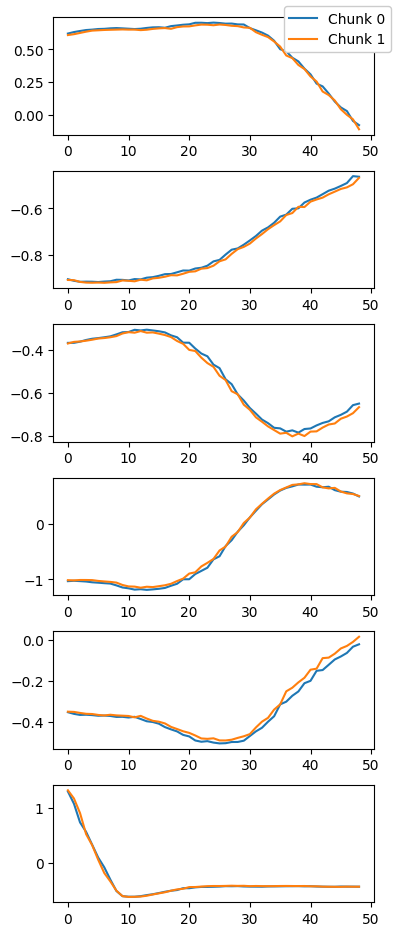

In [10]:
fig, ax = plt.subplots(nrows=6, ncols=1, figsize=(4,10))

for chunk_idx, chunk in enumerate(aligned_chunks):
    for i in range(6):
        current = ax[i]
        
        if i != 5:
            current.plot(chunk[:, i])
        else:
            current.plot(chunk[:, i], label = f"Chunk {chunk_idx}")
        

# Add legend below all subplots
fig.legend(framealpha=1)

# Adjust layout to prevent overlap, leaving space for legend
plt.tight_layout()
plt.subplots_adjust(bottom=0.1)

# PI0

In [11]:
dataset_id = "fracapuano/pi0_finetuned_stacking_action_chunks"

In [12]:
dataset = load_dataset(dataset_id, split="train").with_format("torch")

chunks_differences, frames_diffs = compute_frames_chunks_differences(dataset, n_chunk_in_pairs=2)

100%|██████████| 1599/1599 [03:27<00:00,  7.70it/s]


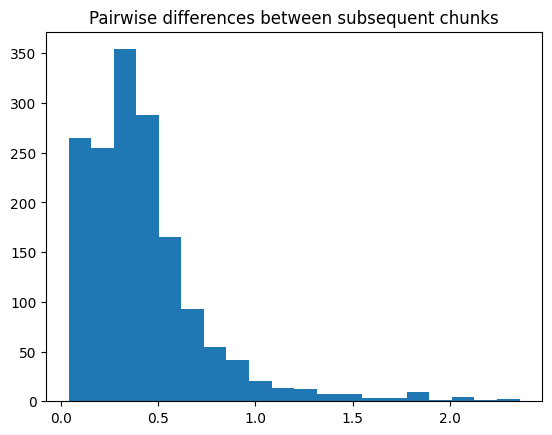

In [13]:
fig, ax = plt.subplots()
ax.hist(chunks_differences, bins=20)

ax.set_title("Pairwise differences between subsequent chunks")
plt.show()

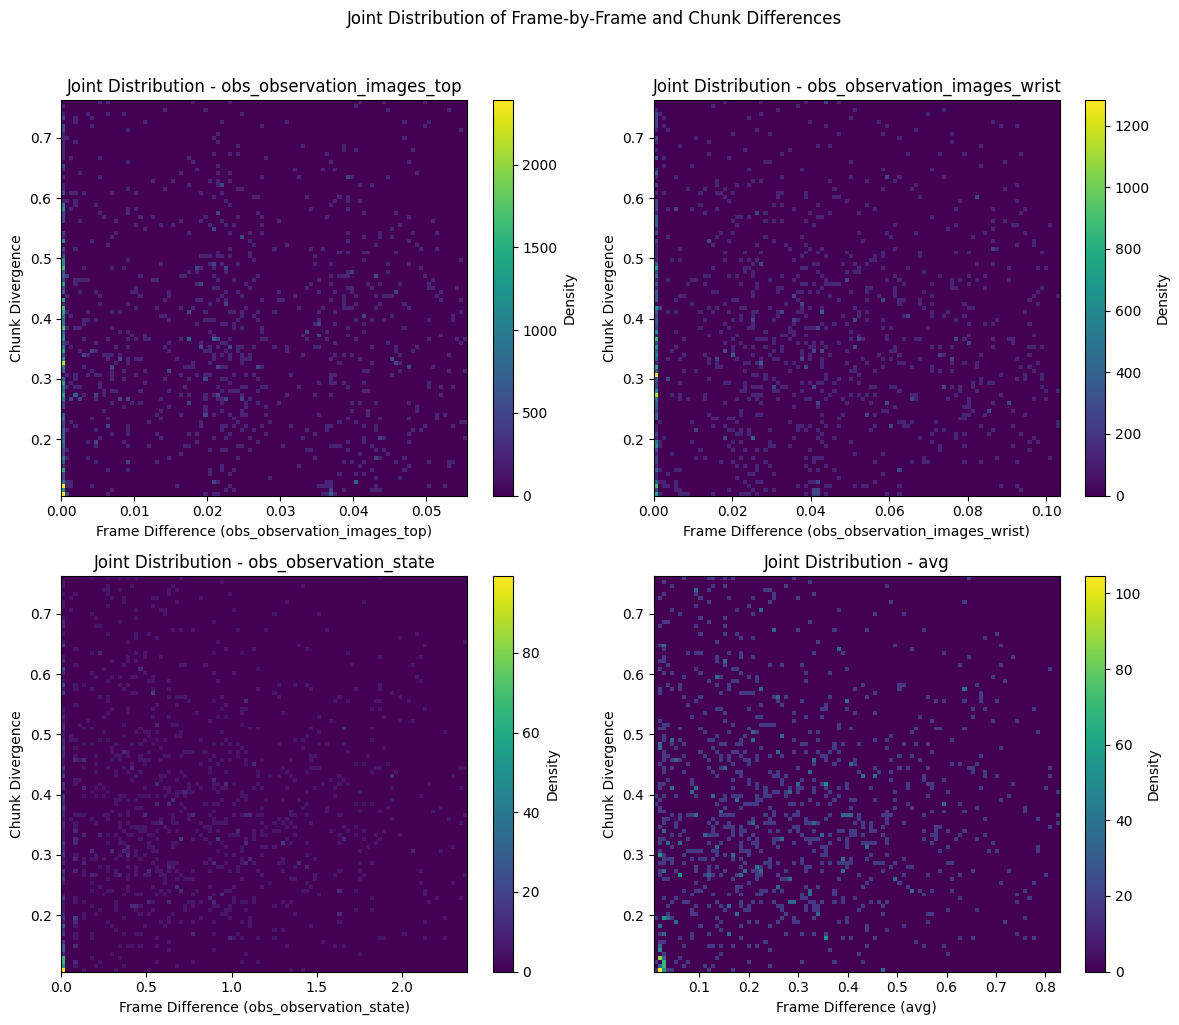

In [14]:
from utils import perceptual_keys, vector_keys
import numpy as np

keys = [*perceptual_keys, *vector_keys, "avg"]
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

for i in range(4):
    current = ax[i//2, i%2]
    
    x = np.array([fd[keys[i]] for fd in frames_diffs])
    y = chunks_differences.numpy()
    
    # Calculate percentile bounds
    x_lower, x_upper = np.percentile(x, [10, 90])
    y_lower, y_upper = np.percentile(y, [10, 90])
    
    # Filter data within the percentile bounds
    mask = (x >= x_lower) & (x <= x_upper) & (y >= y_lower) & (y <= y_upper)
    x = x[mask]
    y = y[mask]
    
    # Create 2D histogram
    h = current.hist2d(
        x, y,
        bins=100,
        density=True  # This normalizes the histogram
    )
    
    # Add colorbar
    plt.colorbar(h[3], ax=current, label='Density')
    
    current.set_xlabel(f'Frame Difference ({keys[i]})')
    current.set_ylabel('Chunk Divergence')
    current.set_title(f'Joint Distribution - {keys[i]}')

fig.suptitle('Joint Distribution of Frame-by-Frame and Chunk Differences', y=1.02)
plt.tight_layout()

In [15]:
avg_distance = torch.tensor([fd[keys[i]] for fd in frames_diffs])
torch.corrcoef(torch.vstack((avg_distance, chunks_differences)))[0,1].item()

0.2595688998699188

In [16]:
pca = reduce_chunks_dim(dataset)

1D projection of action chunk explains variance:  [0.7011104]


In [17]:
avg_distance = torch.tensor([fd[keys[i]] for fd in frames_diffs])
torch.corrcoef(torch.vstack((avg_distance, chunks_differences)))[0,1].item()

0.2595688998699188

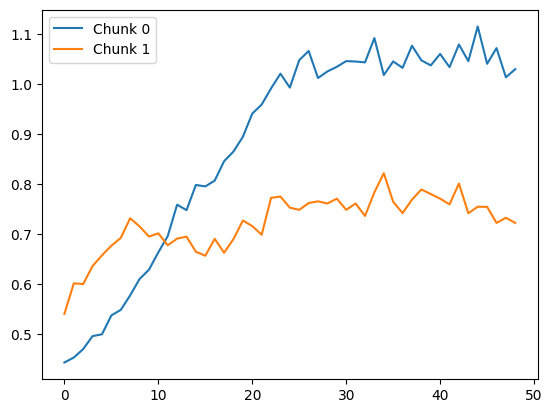

In [18]:
import torch
idx = torch.median(chunks_differences, 0).indices.item()

chunks = dataset[idx:idx+2]["action_chunks"]

aligned_chunks = align_chunks(chunks)
reduced_dim_chunks = [pca.transform(aligned_chunks[i]) for i in range(len(aligned_chunks))]

for i in range(len(reduced_dim_chunks)):
    plt.plot(reduced_dim_chunks[i], label=f"Chunk {i}")

plt.legend()
plt.show()

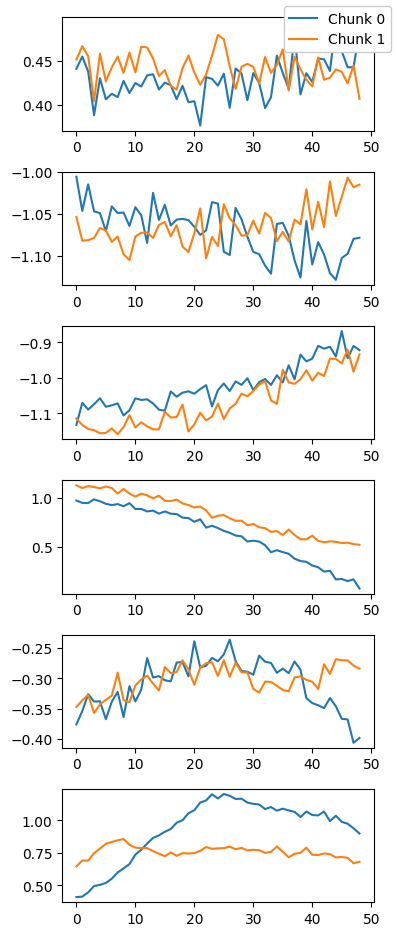

In [19]:
fig, ax = plt.subplots(nrows=6, ncols=1, figsize=(4,10))

for chunk_idx, chunk in enumerate(aligned_chunks):
    for i in range(6):
        current = ax[i]
        
        if i != 5:
            current.plot(chunk[:, i])
        else:
            current.plot(chunk[:, i], label = f"Chunk {chunk_idx}")
        

# Add legend below all subplots
fig.legend(framealpha=1)

# Adjust layout to prevent overlap, leaving space for legend
plt.tight_layout()
plt.subplots_adjust(bottom=0.1)

# SmolVLA

# SmolVLA-5k

In [5]:
dataset_id = "fracapuano/smolvla_finetuned_stacking_action_chunks_5k"

In [6]:
dataset = load_dataset(dataset_id, split="train").with_format("torch")

chunks_differences, frames_diffs = compute_frames_chunks_differences(dataset, n_chunk_in_pairs=2)

100%|██████████| 1599/1599 [03:32<00:00,  7.52it/s]


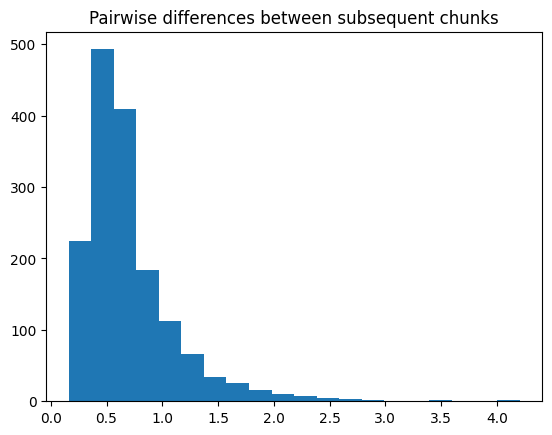

In [7]:
fig, ax = plt.subplots()
ax.hist(chunks_differences, bins=20)

ax.set_title("Pairwise differences between subsequent chunks")
plt.show()

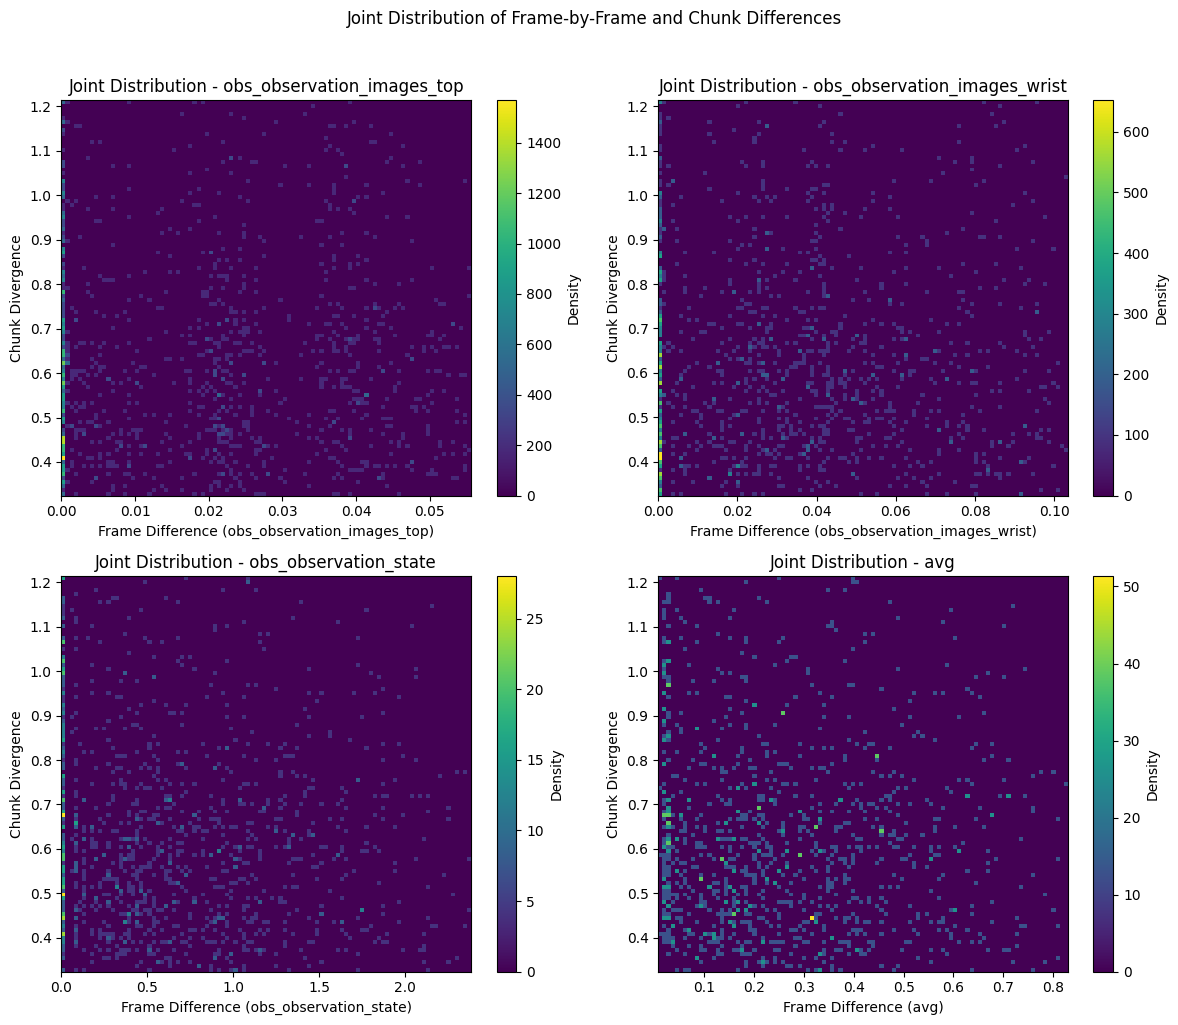

In [8]:
from utils import perceptual_keys, vector_keys
import numpy as np

keys = [*perceptual_keys, *vector_keys, "avg"]
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

for i in range(4):
    current = ax[i//2, i%2]
    
    x = np.array([fd[keys[i]] for fd in frames_diffs])
    y = chunks_differences.numpy()
    
    # Calculate percentile bounds
    x_lower, x_upper = np.percentile(x, [10, 90])
    y_lower, y_upper = np.percentile(y, [10, 90])
    
    # Filter data within the percentile bounds
    mask = (x >= x_lower) & (x <= x_upper) & (y >= y_lower) & (y <= y_upper)
    x = x[mask]
    y = y[mask]
    
    # Create 2D histogram
    h = current.hist2d(
        x, y,
        bins=100,
        density=True  # This normalizes the histogram
    )
    
    # Add colorbar
    plt.colorbar(h[3], ax=current, label='Density')
    
    current.set_xlabel(f'Frame Difference ({keys[i]})')
    current.set_ylabel('Chunk Divergence')
    current.set_title(f'Joint Distribution - {keys[i]}')

fig.suptitle('Joint Distribution of Frame-by-Frame and Chunk Differences', y=1.02)
plt.tight_layout()

In [9]:
avg_distance = torch.tensor([fd[keys[i]] for fd in frames_diffs])
torch.corrcoef(torch.vstack((avg_distance, chunks_differences)))[0,1].item()

-0.16422773897647858

In [10]:
pca = reduce_chunks_dim(dataset)

1D projection of action chunk explains variance:  [0.7704917]


In [11]:
avg_distance = torch.tensor([fd[keys[i]] for fd in frames_diffs])
torch.corrcoef(torch.vstack((avg_distance, chunks_differences)))[0,1].item()

-0.16422773897647858

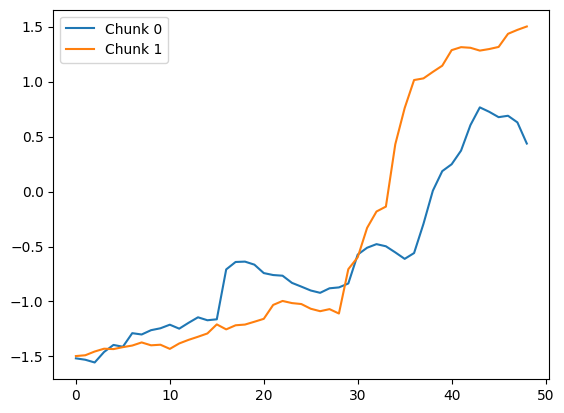

In [12]:
import torch
idx = torch.median(chunks_differences, 0).indices.item()

chunks = dataset[idx:idx+2]["action_chunks"]

aligned_chunks = align_chunks(chunks)
reduced_dim_chunks = [pca.transform(aligned_chunks[i]) for i in range(len(aligned_chunks))]

for i in range(len(reduced_dim_chunks)):
    plt.plot(reduced_dim_chunks[i], label=f"Chunk {i}")

plt.legend()
plt.show()

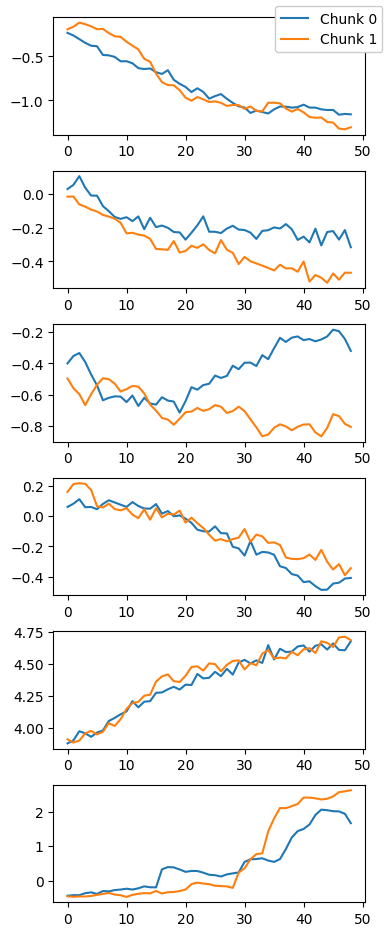

In [13]:
fig, ax = plt.subplots(nrows=6, ncols=1, figsize=(4,10))

for chunk_idx, chunk in enumerate(aligned_chunks):
    for i in range(6):
        current = ax[i]
        
        if i != 5:
            current.plot(chunk[:, i])
        else:
            current.plot(chunk[:, i], label = f"Chunk {chunk_idx}")
        

# Add legend below all subplots
fig.legend(framealpha=1)

# Adjust layout to prevent overlap, leaving space for legend
plt.tight_layout()
plt.subplots_adjust(bottom=0.1)

# SmolVLA-10k

In [16]:
dataset_id = "fracapuano/smolvla_finetuned_stacking_action_chunks_10k"

In [17]:
dataset = load_dataset(dataset_id, split="train").with_format("torch")

chunks_differences, frames_diffs = compute_frames_chunks_differences(dataset, n_chunk_in_pairs=2)

100%|██████████| 1599/1599 [03:22<00:00,  7.91it/s]


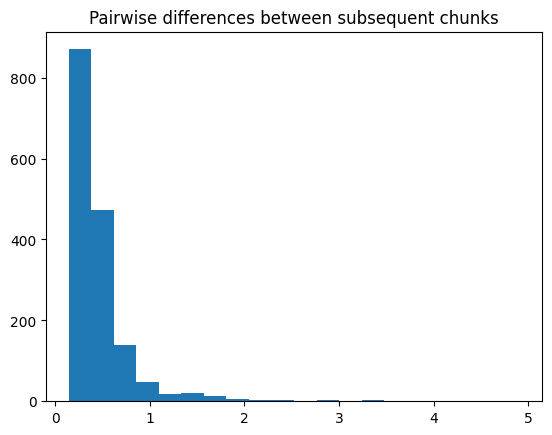

In [18]:
fig, ax = plt.subplots()
ax.hist(chunks_differences, bins=20)

ax.set_title("Pairwise differences between subsequent chunks")
plt.show()

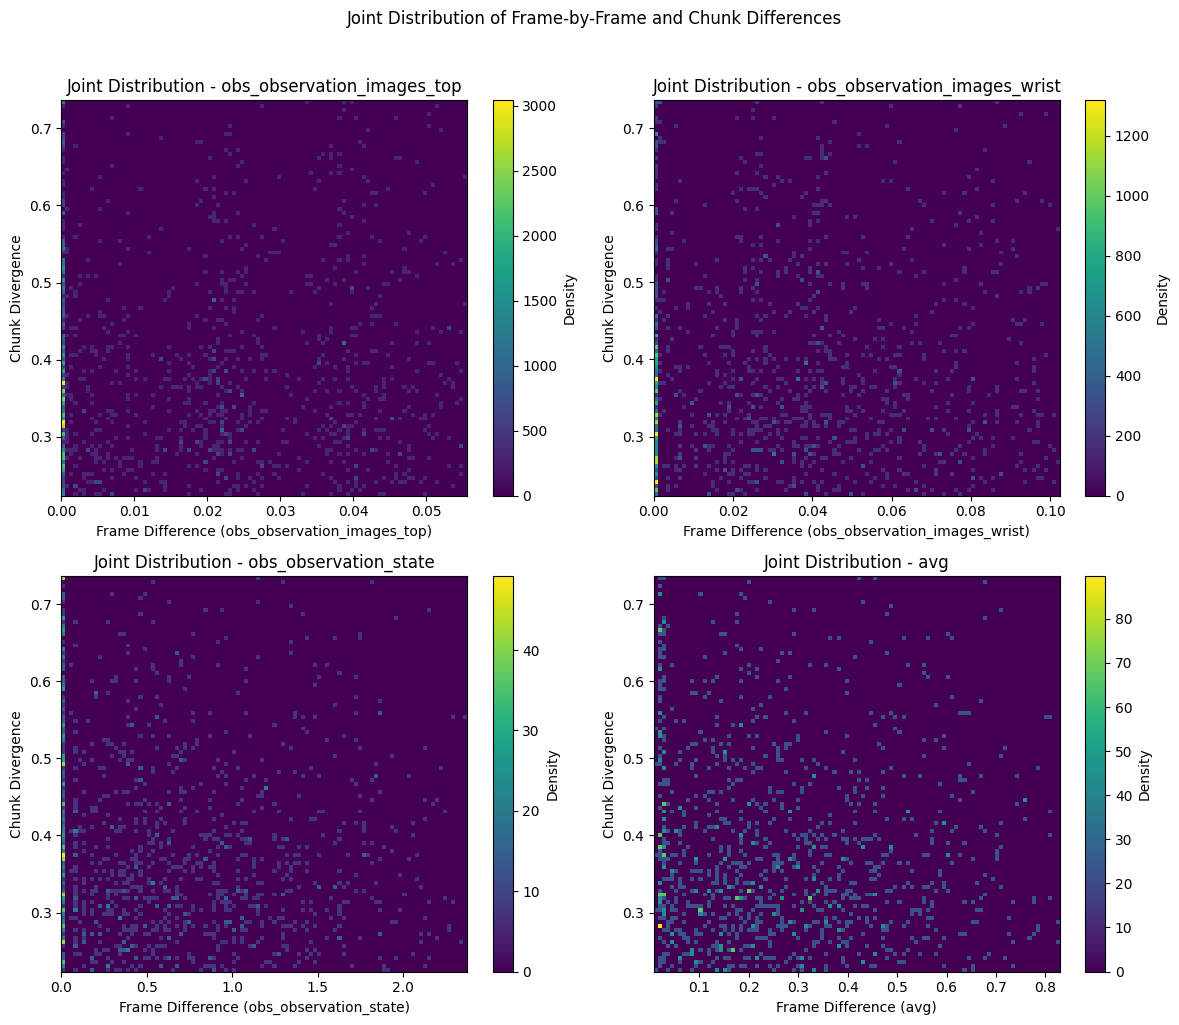

In [19]:
from utils import perceptual_keys, vector_keys
import numpy as np

keys = [*perceptual_keys, *vector_keys, "avg"]
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

for i in range(4):
    current = ax[i//2, i%2]
    
    x = np.array([fd[keys[i]] for fd in frames_diffs])
    y = chunks_differences.numpy()
    
    # Calculate percentile bounds
    x_lower, x_upper = np.percentile(x, [10, 90])
    y_lower, y_upper = np.percentile(y, [10, 90])
    
    # Filter data within the percentile bounds
    mask = (x >= x_lower) & (x <= x_upper) & (y >= y_lower) & (y <= y_upper)
    x = x[mask]
    y = y[mask]
    
    # Create 2D histogram
    h = current.hist2d(
        x, y,
        bins=100,
        density=True  # This normalizes the histogram
    )
    
    # Add colorbar
    plt.colorbar(h[3], ax=current, label='Density')
    
    current.set_xlabel(f'Frame Difference ({keys[i]})')
    current.set_ylabel('Chunk Divergence')
    current.set_title(f'Joint Distribution - {keys[i]}')

fig.suptitle('Joint Distribution of Frame-by-Frame and Chunk Differences', y=1.02)
plt.tight_layout()

In [20]:
avg_distance = torch.tensor([fd[keys[i]] for fd in frames_diffs])
torch.corrcoef(torch.vstack((avg_distance, chunks_differences)))[0,1].item()

-0.09050958603620529

In [21]:
pca = reduce_chunks_dim(dataset)

1D projection of action chunk explains variance:  [0.7473848]


In [22]:
avg_distance = torch.tensor([fd[keys[i]] for fd in frames_diffs])
torch.corrcoef(torch.vstack((avg_distance, chunks_differences)))[0,1].item()

-0.09050958603620529

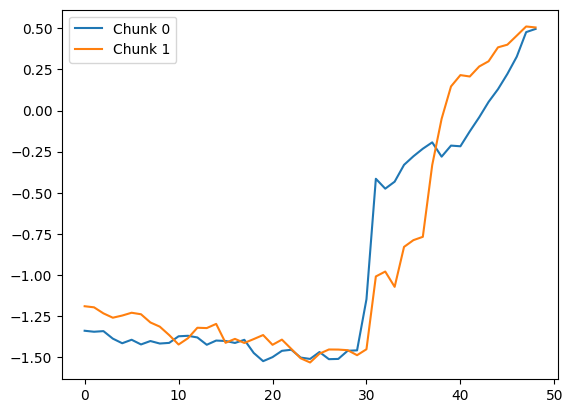

In [23]:
import torch
idx = torch.median(chunks_differences, 0).indices.item()

chunks = dataset[idx:idx+2]["action_chunks"]

aligned_chunks = align_chunks(chunks)
reduced_dim_chunks = [pca.transform(aligned_chunks[i]) for i in range(len(aligned_chunks))]

for i in range(len(reduced_dim_chunks)):
    plt.plot(reduced_dim_chunks[i], label=f"Chunk {i}")

plt.legend()
plt.show()

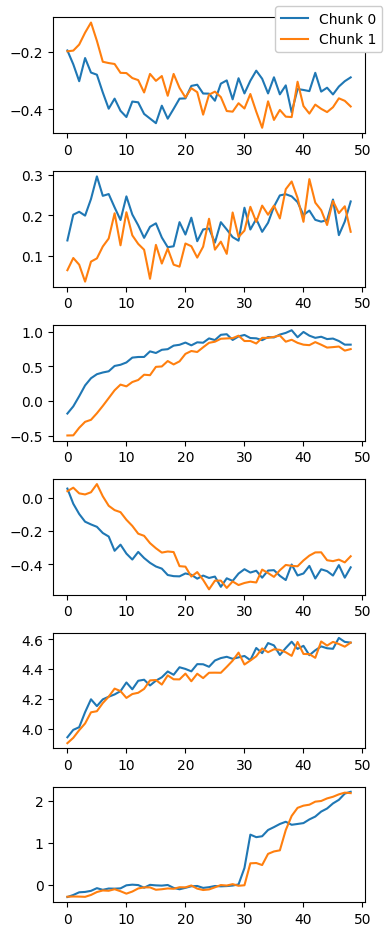

In [24]:
fig, ax = plt.subplots(nrows=6, ncols=1, figsize=(4,10))

for chunk_idx, chunk in enumerate(aligned_chunks):
    for i in range(6):
        current = ax[i]
        
        if i != 5:
            current.plot(chunk[:, i])
        else:
            current.plot(chunk[:, i], label = f"Chunk {chunk_idx}")
        

# Add legend below all subplots
fig.legend(framealpha=1)

# Adjust layout to prevent overlap, leaving space for legend
plt.tight_layout()
plt.subplots_adjust(bottom=0.1)

# SmolVLA-15k

In [25]:
dataset_id = "fracapuano/smolvla_finetuned_stacking_action_chunks_15k"

In [26]:
dataset = load_dataset(dataset_id, split="train").with_format("torch")

chunks_differences, frames_diffs = compute_frames_chunks_differences(dataset, n_chunk_in_pairs=2)

100%|██████████| 1599/1599 [03:20<00:00,  7.96it/s]


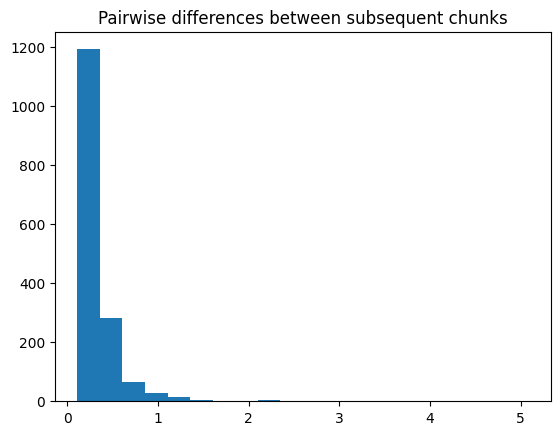

In [27]:
fig, ax = plt.subplots()
ax.hist(chunks_differences, bins=20)

ax.set_title("Pairwise differences between subsequent chunks")
plt.show()

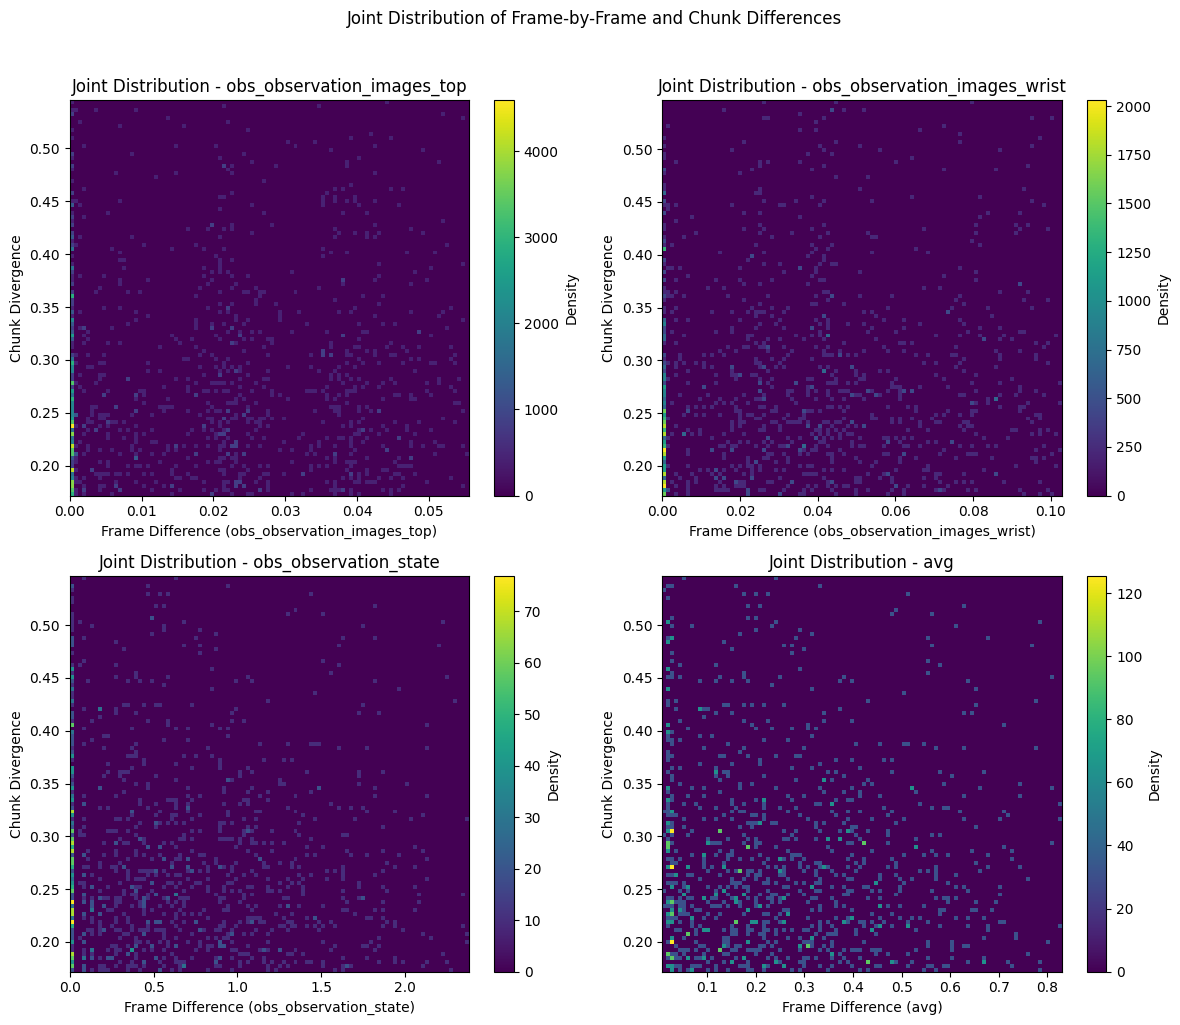

In [28]:
from utils import perceptual_keys, vector_keys
import numpy as np

keys = [*perceptual_keys, *vector_keys, "avg"]
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

for i in range(4):
    current = ax[i//2, i%2]
    
    x = np.array([fd[keys[i]] for fd in frames_diffs])
    y = chunks_differences.numpy()
    
    # Calculate percentile bounds
    x_lower, x_upper = np.percentile(x, [10, 90])
    y_lower, y_upper = np.percentile(y, [10, 90])
    
    # Filter data within the percentile bounds
    mask = (x >= x_lower) & (x <= x_upper) & (y >= y_lower) & (y <= y_upper)
    x = x[mask]
    y = y[mask]
    
    # Create 2D histogram
    h = current.hist2d(
        x, y,
        bins=100,
        density=True  # This normalizes the histogram
    )
    
    # Add colorbar
    plt.colorbar(h[3], ax=current, label='Density')
    
    current.set_xlabel(f'Frame Difference ({keys[i]})')
    current.set_ylabel('Chunk Divergence')
    current.set_title(f'Joint Distribution - {keys[i]}')

fig.suptitle('Joint Distribution of Frame-by-Frame and Chunk Differences', y=1.02)
plt.tight_layout()

In [29]:
avg_distance = torch.tensor([fd[keys[i]] for fd in frames_diffs])
torch.corrcoef(torch.vstack((avg_distance, chunks_differences)))[0,1].item()

0.02265051193535328

In [30]:
pca = reduce_chunks_dim(dataset)

1D projection of action chunk explains variance:  [0.765004]


In [31]:
avg_distance = torch.tensor([fd[keys[i]] for fd in frames_diffs])
torch.corrcoef(torch.vstack((avg_distance, chunks_differences)))[0,1].item()

0.02265051193535328

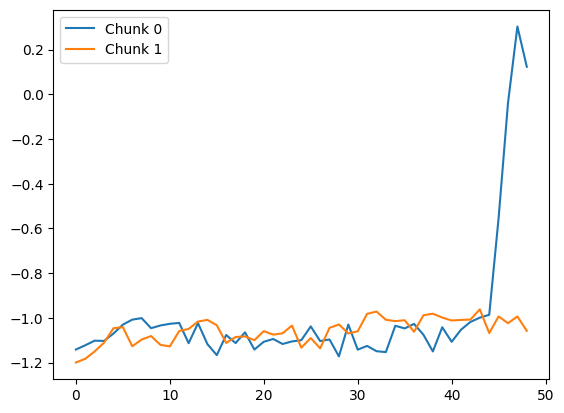

In [32]:
import torch
idx = torch.median(chunks_differences, 0).indices.item()

chunks = dataset[idx:idx+2]["action_chunks"]

aligned_chunks = align_chunks(chunks)
reduced_dim_chunks = [pca.transform(aligned_chunks[i]) for i in range(len(aligned_chunks))]

for i in range(len(reduced_dim_chunks)):
    plt.plot(reduced_dim_chunks[i], label=f"Chunk {i}")

plt.legend()
plt.show()

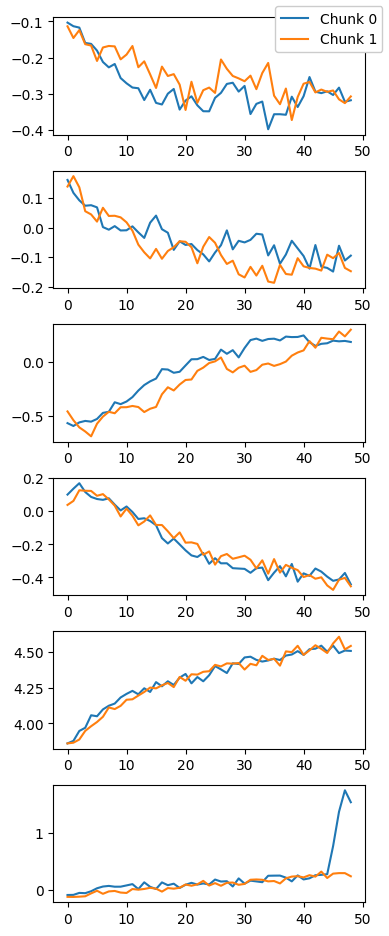

In [33]:
fig, ax = plt.subplots(nrows=6, ncols=1, figsize=(4,10))

for chunk_idx, chunk in enumerate(aligned_chunks):
    for i in range(6):
        current = ax[i]
        
        if i != 5:
            current.plot(chunk[:, i])
        else:
            current.plot(chunk[:, i], label = f"Chunk {chunk_idx}")
        

# Add legend below all subplots
fig.legend(framealpha=1)

# Adjust layout to prevent overlap, leaving space for legend
plt.tight_layout()
plt.subplots_adjust(bottom=0.1)

# SmolVLA-20k

In [34]:
dataset_id = "fracapuano/smolvla_finetuned_stacking_action_chunks_20k"

In [35]:
dataset = load_dataset(dataset_id, split="train").with_format("torch")

chunks_differences, frames_diffs = compute_frames_chunks_differences(dataset, n_chunk_in_pairs=2)

100%|██████████| 1599/1599 [03:23<00:00,  7.85it/s]


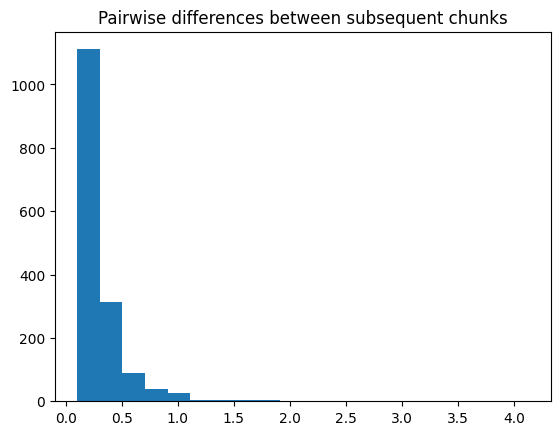

In [36]:
fig, ax = plt.subplots()
ax.hist(chunks_differences, bins=20)

ax.set_title("Pairwise differences between subsequent chunks")
plt.show()

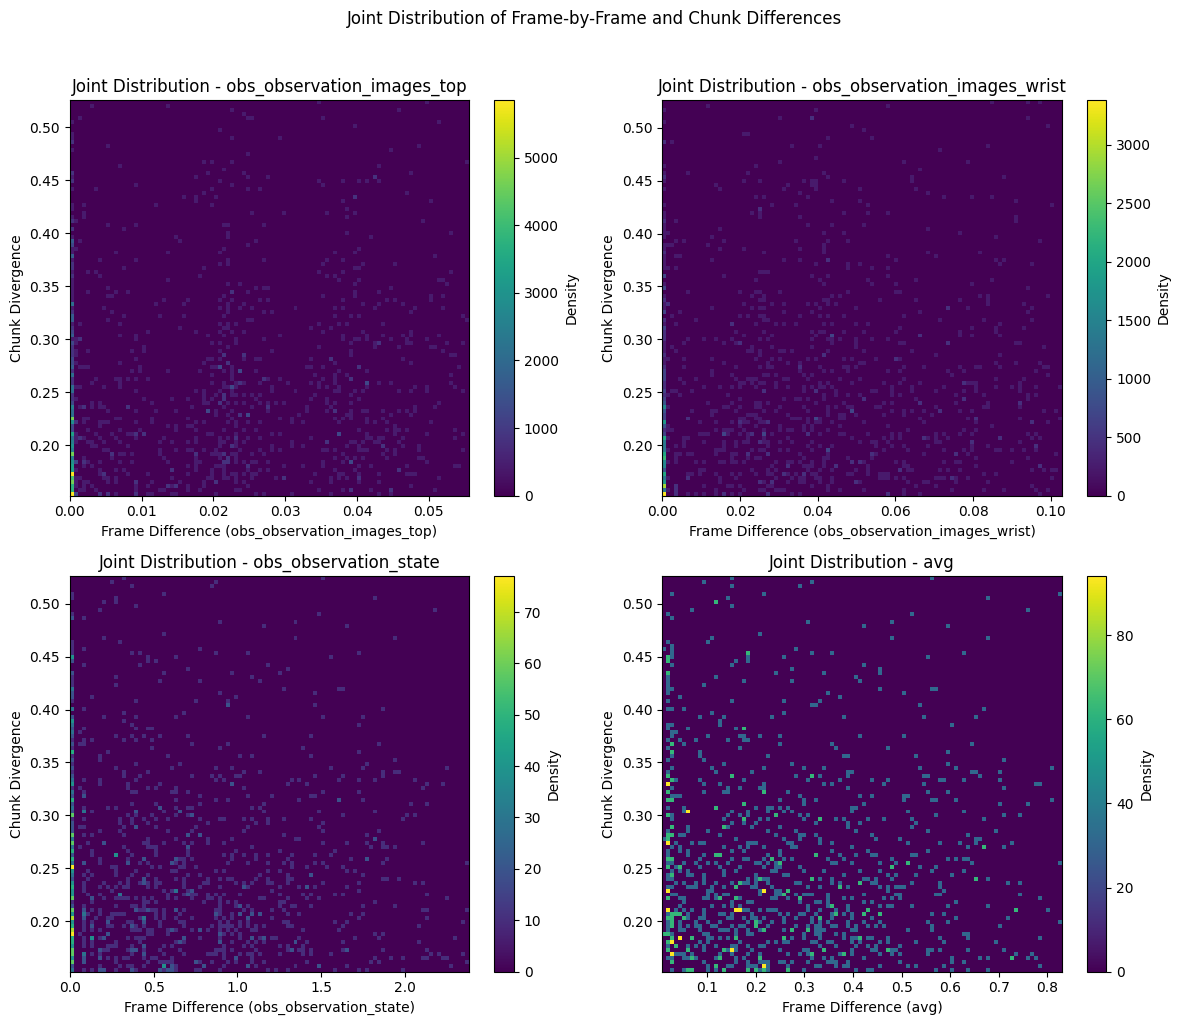

In [37]:
from utils import perceptual_keys, vector_keys
import numpy as np

keys = [*perceptual_keys, *vector_keys, "avg"]
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

for i in range(4):
    current = ax[i//2, i%2]
    
    x = np.array([fd[keys[i]] for fd in frames_diffs])
    y = chunks_differences.numpy()
    
    # Calculate percentile bounds
    x_lower, x_upper = np.percentile(x, [10, 90])
    y_lower, y_upper = np.percentile(y, [10, 90])
    
    # Filter data within the percentile bounds
    mask = (x >= x_lower) & (x <= x_upper) & (y >= y_lower) & (y <= y_upper)
    x = x[mask]
    y = y[mask]
    
    # Create 2D histogram
    h = current.hist2d(
        x, y,
        bins=100,
        density=True  # This normalizes the histogram
    )
    
    # Add colorbar
    plt.colorbar(h[3], ax=current, label='Density')
    
    current.set_xlabel(f'Frame Difference ({keys[i]})')
    current.set_ylabel('Chunk Divergence')
    current.set_title(f'Joint Distribution - {keys[i]}')

fig.suptitle('Joint Distribution of Frame-by-Frame and Chunk Differences', y=1.02)
plt.tight_layout()

In [38]:
avg_distance = torch.tensor([fd[keys[i]] for fd in frames_diffs])
torch.corrcoef(torch.vstack((avg_distance, chunks_differences)))[0,1].item()

0.005538766272366047

In [39]:
pca = reduce_chunks_dim(dataset)

1D projection of action chunk explains variance:  [0.7653127]


In [40]:
avg_distance = torch.tensor([fd[keys[i]] for fd in frames_diffs])
torch.corrcoef(torch.vstack((avg_distance, chunks_differences)))[0,1].item()

0.005538766272366047

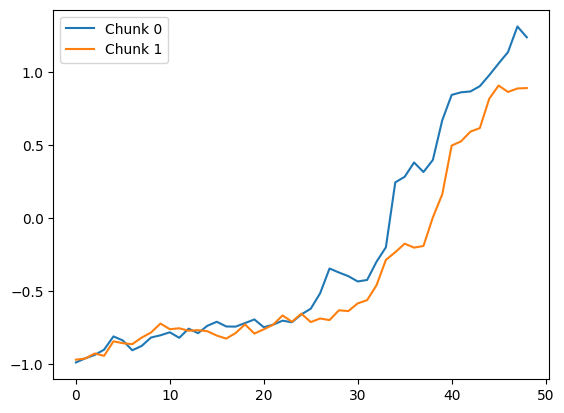

In [41]:
import torch
idx = torch.median(chunks_differences, 0).indices.item()

chunks = dataset[idx:idx+2]["action_chunks"]

aligned_chunks = align_chunks(chunks)
reduced_dim_chunks = [pca.transform(aligned_chunks[i]) for i in range(len(aligned_chunks))]

for i in range(len(reduced_dim_chunks)):
    plt.plot(reduced_dim_chunks[i], label=f"Chunk {i}")

plt.legend()
plt.show()

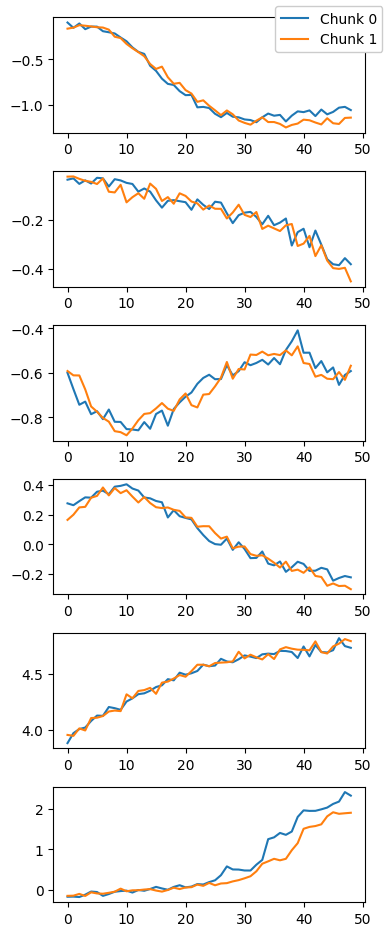

In [42]:
fig, ax = plt.subplots(nrows=6, ncols=1, figsize=(4,10))

for chunk_idx, chunk in enumerate(aligned_chunks):
    for i in range(6):
        current = ax[i]
        
        if i != 5:
            current.plot(chunk[:, i])
        else:
            current.plot(chunk[:, i], label = f"Chunk {chunk_idx}")
        

# Add legend below all subplots
fig.legend(framealpha=1)

# Adjust layout to prevent overlap, leaving space for legend
plt.tight_layout()
plt.subplots_adjust(bottom=0.1)